# Build a Delft-FIAT model anywhere in the world with OSM and JRC data

This notebook guides the user through the workflow of creating a Delft-FIAT model for any location in the world where OpenStreetMap (OSM) data is available. In this example, a model is created of Kingston upon Hull, a city in the Humber delta in the United Kingdom. The area of interest can be changed to create a Delft-FIAT model for any other location globally.

*Disclaimer: The outcomes of this model are not validated*

## **Step 0**: Import required packages
First we need to import the necessary python packages.

In [ ]:
# import required packages
import os
from hydromt_fiat.fiat import FiatModel
from hydromt.log import setuplog
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import shutil
%matplotlib inline

## **Step 1a**: Configure - initialization
Then we will set up the configuration to initialize HydroMT-FIAT. The following parameters should be defined by the user:
- `model_root`: the path to a folder where the model should be created in
- `model_name`: the name of the model

In [ ]:
model_root = 'FIAT_database'  # where to save the FIAT model
model_name = "example" # name of the case study

And these parameters are predefined and should remain the same:
- `model_folder`: the full path to the to be created model folder (`model_root` + `model_name`)
- `data_catalog`: the relative path to the HydroMT-FIAT global data catalog
- `logger_name`: the log-file name. A logger object is also initialized below.

In [ ]:
model_folder = Path(model_root) / model_name  # full path to model folder
data_catalog = Path(os.path.abspath("")) / ".." / "hydromt_fiat" / "data" / "hydromt_fiat_catalog_global.yml"  # path to data catalog relative to this notebook
logger_name = "hydromt_fiat"  # name of the logger
logger = setuplog(logger_name, log_level=10) # setup logger

## **Step 1b**: Configure - model setup
In this step we will set up the model configuration including the spatial boundary of the model. We start with that.

Go to http://geojson.io and draw a polygon at the location of your choice. In this example, we are interested in Kingston upon Hull, UK. We copied the GeoJSON description on the right of the website and assigned that to the `area_of_interest` below. 

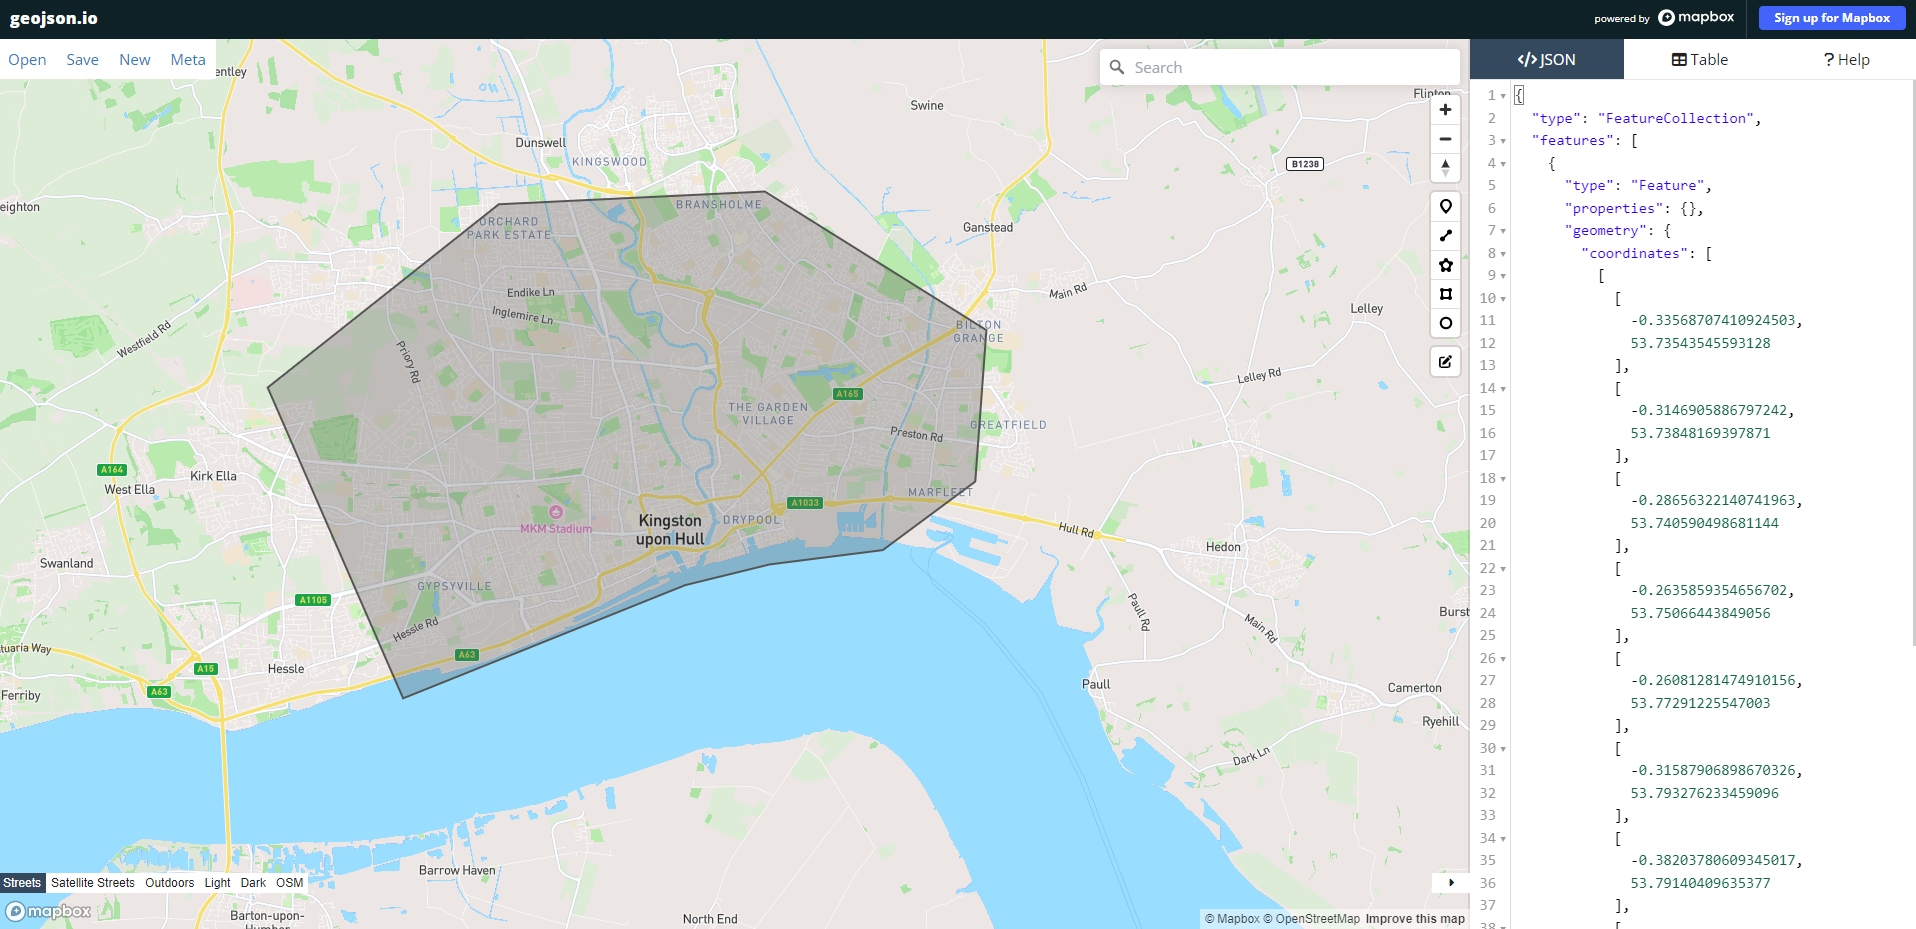

In [ ]:
area_of_interest = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "coordinates": [
                    [
                        [-0.33568707410924503, 53.73543545593128],
                        [-0.3146905886797242, 53.73848169397871],
                        [-0.28656322140741963, 53.740590498681144],
                        [-0.2635859354656702, 53.75066443849056],
                        [-0.26081281474910156, 53.77291225547003],
                        [-0.31587906898670326, 53.793276233459096],
                        [-0.38203780609345017, 53.79140409635377],
                        [-0.4394810209459763, 53.76448289075884],
                        [-0.4058074122395965, 53.71879441377928],
                        [-0.33568707410924503, 53.73543545593128],
                    ]
                ],
                "type": "Polygon",
            },
        }
    ],
}

Next, please choose the continent and country of your area of interest:
- `continent`: the name of the continent where your area of interest is located. Please choose one of the following: Europe, North America, Central America, South America, Asia, Africa, Oceania, or Global
- `country`: the name of the country where your area of interest is located.

In [ ]:
continent = "Europe"
country = "United Kingdom"

These following parameters are predefined:

**Vulnerability**
- `vulnerability_fn`: the name of JRC global vulnerability curves as defined in the HydroMT-FIAT global data catalog
- `vulnerability_identifiers_and_linking_fn`: the name of the default *occupancy type-vulnerability curves* linking table for linking the OSM land use classes to the JRC global vulnerability curves. The file is defined in the HydroMT-FIAT global data catalog
- `unit`: the unit of the vulnerability curves. The JRC curves are standard in meters

**Exposure**
- `asset_locations`: the source containing the location and (optionally) geometry of the assests for which damages will be calculated. In this example, the building footprints from OSM are used.
- `occupancy_type`: the source containing the occupancy type to classify the assets with. In this example, the land use data from OSM is used.
- `max_potential_damage`: the source containing the maximum potential damage values. In this example, the JRC maximum damage values are used.
- `ground_floor_height`: the height of the ground floor of all assets, in the same `ground_floor_height_unit`
- `ground_floor_height_unit`: the ground floor height unit

**Output**
- `output_dir`: the name of the output directory
- `output_csv_name`: the name of the output CSV
- `output_vector_name`: the name of the vector output file(s)

In [ ]:
### Setup vulnerability parameters ###
vulnerability_fn = "jrc_vulnerability_curves"
vulnerability_identifiers_and_linking_fn = "jrc_vulnerability_curves_linking"
unit = "m"

### Setup exposure parameters ###
asset_locations = "OSM"
occupancy_type = "OSM"
max_potential_damage = "jrc_damage_values"
ground_floor_height = 0
ground_floor_height_unit = "m"

### Setup output parameters ###
output_dir = "output"
output_csv_name = "output.csv"
output_vector_name = "spatial.gpkg"

Now, a dictionary is made from the configurations chosen above.

In [ ]:
configuration = {
    "setup_output": {
        "output_dir": output_dir,
        "output_csv_name": output_csv_name,
        "output_vector_name": output_vector_name,
    },
    "setup_vulnerability": {
        "vulnerability_fn": vulnerability_fn,
        "vulnerability_identifiers_and_linking_fn": vulnerability_identifiers_and_linking_fn,
        "continent": continent,
        "unit": unit,
    },
    "setup_exposure_vector": {
        "asset_locations": asset_locations,
        "occupancy_type": occupancy_type,
        "max_potential_damage": max_potential_damage,
        "ground_floor_height": ground_floor_height,
        "ground_floor_height_unit": ground_floor_height_unit,
        "country": country,
    },
}

## **Step 2**: Initialize
In this step we initialize HydroMT-FIAT with the `model_folder`, `data_catalog`, and `logger` that we defined above.

*Note that if the `model_folder` already exists, it is deleted before initializing HydroMT-FIAT.*

In [ ]:
if model_folder.exists():
    shutil.rmtree(model_folder)
fiat_model = FiatModel(root=model_folder, mode="w", data_libs=[data_catalog], logger=logger)

## **Step 3**: Build
In this step we build the Delft-FIAT model. Depending on the extent of the model it can take some time to download the building footprints and land use data from OSM. During the building of the model log messages display what is happening. We can inspect the created exposure data spatially.

*Note that the model will not yet be written because of setting the write argument to False.*

In [ ]:
region = gpd.GeoDataFrame.from_features(area_of_interest, crs="EPSG:4326")
fiat_model.build(region={"geom": region}, opt=configuration, write=False)

## **Step 4a**: Inspect model
We now inspect the `fiat_model` considering the exposure data and vulnerability curves.

### Exposure data
In the map below, the region and Secondary Object Type of the exposure objects are plotted. You can zoom in and see whether the data makes sense, perhaps using Google maps and/or streetview to validate the occupancy types.

*Note: In Delft-FIAT, exposure is defined with object footprints, lines or centroids. In this example we are only going to use the buildings extracted from the OSM data. This means we are not going to look into, e.g., farmland, roads, etc. but that is possible with Delft-FIAT.*

In [ ]:
# Get the geodataframe with exposure data
gdf = fiat_model.exposure.get_full_gdf(fiat_model.exposure.exposure_db)

# Plot the region and the secondary object types of the exposure data
m = region.explore(name='Region', style_kwds={'color': 'black', 'fill': False})
m = gdf.explore(m=m, column='Secondary Object Type', name='Exposure types')
m

### Maximum potential damage values
The next thing we inspect are the maximum potential damage values. The total direct damages to buildings from a flood can be related to structural and content damages.

The maximum structural potential damage of a building is associated with the construction costs, the size of the building and the depreciated value of the building after the flood. For an accurate flood damage assessment this information is required at the building level. However, often this is not available. Therefore, the buildings are usually classified based on their material and usage type, and assigned a generalized maximum potential damage per m<sup>2</sup> per class.

In this example, the maximum potential damage values per m<sup>2</sup> from a global study from JRC<sup>1</sup> are used.

In this case the maximum potential damage is in USD 2020. By multiplying the maximum potential damage values per m<sup>2</sup> with the area of the building footprints, we derive the maximum potential structure damage value for each of our exposure assets. You can see this in the map below.

<sup>1</sup> https://publications.jrc.ec.europa.eu/repository/handle/JRC105688

In [ ]:
gdf.explore(column='Max Potential Damage: Structure')

### Vulnerability curves
Each of these buildings has a maximum potential damage that can be inflicted by a flood, which is associated with structural damages (e.g., to the walls) or damage to contents (e.g., to the furniture). 

There are methods to derive these values, based on building type (e.g., residential or commercial, building material etc.) and the area of the building. JRC has also made global maximum damage curves and values available<sup>1</sup>, but it is recommended to use more location-specific damage values. In the US, FEMA Hazus<sup>2</sup> is an industry standard in how to derive these curves and values values.

In this example we want to demonstrate a method that works globally, and thus we are going to use a simple classification of the buildings based on land-use and then we are going to scale the maximum potential damage using the footprint area of each building and a value/m<sup>2</sup> for each land-cover type.

<sup>1</sup> https://publications.jrc.ec.europa.eu/repository/handle/JRC105688

<sup>2</sup> https://www.fema.gov/flood-maps/tools-resources/flood-map-products/hazus/user-technical-manuals


In [ ]:
water_depths = fiat_model.vulnerability.hazard_values
line_styles = ['--', '-', ':']
for function_name, ls in zip(fiat_model.vulnerability.functions.keys(), line_styles):
    dmg = [float(i) for i in fiat_model.vulnerability.functions[function_name]]
    plt.plot(water_depths, dmg, label=function_name, ls=ls)
plt.xlabel('depth (m)')
plt.ylabel('damage fraction (-)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

## **Step 5**: Write
In this final step, the FIAT model is written to the `model_folder` in the folder structure that is required for Delft-FIAT.

In [ ]:
fiat_model.write()